In [4]:
from math import radians, cos, sin, asin, sqrt

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Functions.air_traffic_data import AirTrafficData

In [6]:
import pandas as pd

In [7]:
import os

In [8]:
import sys
sys.path.append('Functions')
from distance_calculator import haversine

In [13]:
class AirTrafficData:
    """Initializes the class by loading datasets into pandas DataFrames."""

    def __init__(self):
        self.airlines_df = self.load_csv('downloads/airlines.csv')
        self.airplanes_df = self.load_csv('downloads/airplanes.csv')
        self.airports_df = self.load_csv('downloads/airports.csv')
        self.routes_df = self.load_csv('downloads/routes.csv')

    def load_csv(self, file_path):
        """
        Loads a CSV file into a pandas DataFrame.

        Parameters:
        - file_path: The path to the CSV file to load.

        Returns:
        A pandas DataFrame containing the data from the CSV file.
        """
        if os.path.exists(file_path):
            return pd.read_csv(file_path)
        else:
            raise FileNotFoundError(f"The file {file_path} does not exist.")

    def calculate_distance(self, airport_code1, airport_code2):
        """
        Calculates the distance between two airports.

        Parameters:
        - airport_code1: The IATA code of the first airport.
        - airport_code2: The IATA code of the second airport.

        Returns:
        The distance in kilometers between the two airports.
        """
        if airport_code1 not in self.airports_df['IATA'].values or airport_code2 not in self.airports_df['IATA'].values:
             return None
            
        coords1 = self.airports_df[self.airports_df['IATA'] == airport_code1]\
            [['Latitude', 'Longitude']].iloc[0]
        coords2 = self.airports_df[self.airports_df['IATA'] == airport_code2]\
            [['Latitude', 'Longitude']].iloc[0]

        return haversine(
            coords1['Longitude'], coords1['Latitude'], 
            coords2['Longitude'], coords2['Latitude']
        )

    def distance_analysis(self):
        """
        Perform distance analysis on routes data.

        This method calculates the distances between source and destination airports for each route in the dataset.
        It utilizes the calculate_distance method to compute the distance between two airports based on their IATA codes.
        The distances are then stored in a new column 'Distance' in the DataFrame.

        Returns:
        A histogram showing the distribution of distances between source and destination airports.
        """
        routes = self.routes_df[["Source airport ID", "Destination airport ID"]]
        airports = self.airports_df[["Airport ID", "IATA"]].copy()

        #Joining dataframes & data cleaning
        airports.loc[:, "Airport ID"] = airports["Airport ID"].astype(str)
        data = routes.merge(airports, left_on="Source airport ID", right_on="Airport ID", how="left") \
             .merge(airports, left_on="Destination airport ID", right_on="Airport ID", how="left")

        data.rename(columns={"IATA_x": "Source-IATA", "IATA_y": "Destination-IATA"}, inplace=True)
        data.drop(columns=["Airport ID_x", "Airport ID_y"], inplace=True)

        data["Distance"] = data.apply(lambda row: self.calculate_distance(row["Source-IATA"], row["Destination-IATA"]), axis=1)
        
        return data["Distance"].hist() 

    
    def plot_airports_by_country(self, country_name):
        """ 
        Takes a country as an input and plots a map 
        with the locations of its airports (as well as a map for that country)

        Parameters: 
        - country_name: Name of the country to plot 

        Returns: 
        A map of the country's boarders with red dots indicating the airports
        """
    
        # Filter the airports dataframe for the specified country
        country_airports = self.airports_df[self.airports_df['Country'].str.lower() == country_name.lower()]

        # Check if any airports are found for the country
        if country_airports.empty:
            return f"No airports found for the country: {country_name}. Please check the country name and try again."

        # Plotting setup
        fig, ax = plt.subplots(figsize=(10, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())

        lats = country_airports['Latitude'].values
        longs = country_airports['Longitude'].values

         # Create a Cartopy map of the world
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.set_extent([min(longs) - 5, max(longs) + 5, min(lats) - 5, max(lats) + 5])

        # Plot airports
        ax.scatter(longs, lats, transform=ccrs.PlateCarree(), color='red', marker='o', zorder=5)

        plt.title(f"Airports in {country_name}")
        plt.show()

    
    def most_used_airplane_models(self, N, country=None):
        """
        Retrieve the N most frequently used airplane models based on the number of routes they operate.

        Parameters:
        - N (int): The number of airplane models to retrieve.
        - country (str or list of str, optional): A string or a list of country names to filter the data. 
          If provided, only routes from the specified countries will be considered. 
          If None (default), data from all countries will be included.

        Returns:
        pandas.Series: A Series containing the counts of routes for each airplane model, 
        indexed by the airplane model name, sorted in descending order of route counts.
        """
        airports = self.airports_df[["Airport ID", "Country", "IATA"]]
        routes = self.routes_df[["Source airport ID", "Destination airport ID"]]
        airplanes = self.airplanes_df[["Name","IATA code"]]

        #Joining dataframes & data cleaning
        airports.loc[:, "Airport ID"] = airports["Airport ID"].astype(str)
        routes_adv = routes.join(airports.set_index("Airport ID"), on ="Source airport ID")
        data = routes_adv.join(airplanes.set_index("IATA code"), on ="IATA")
        data = data[(data["Name"].notna()) & (data["IATA"] != "\\N")]
        if country != None:
             if isinstance(country, str):
                 country = [country]  
             return data[data["Country"].isin(country)].groupby("Name").size().nlargest(N)
        else:
             return data.groupby("Name").size().nlargest(N)
    
        

**Playground to play around**

In [10]:
probe = AirTrafficData()

/var/folders/_j/f96rrhbn7sn9rhplqnfbww180000gn/T/ipykernel_5049/1215156729.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '2' '3' ... '14108' '14109' '14110']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  airports.loc[:, "Airport ID"] = airports["Airport ID"].astype(str)


<Axes: >

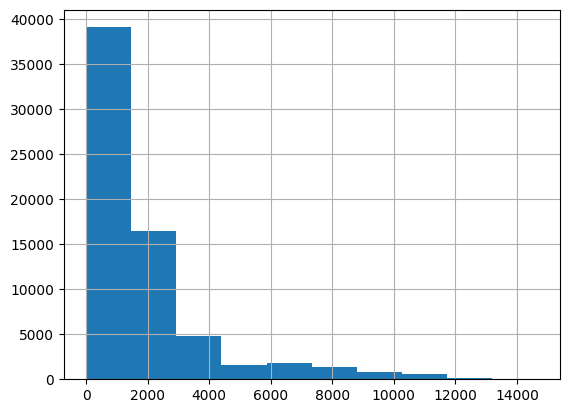

In [11]:
probe.distance_analysis()

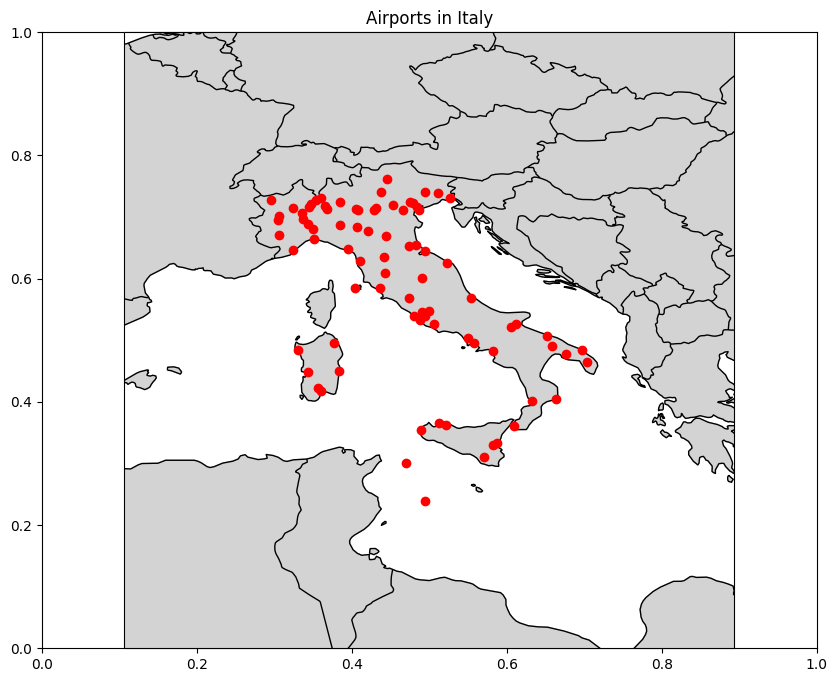

In [12]:
probe.plot_airports_by_country('Italy')